In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Load the Data Set for Seattle

In [2]:
# Connect to the database
database = "/Users/zachcuddihy/Projects/apartment_scraper/data/apartments.db"
conn = create_connection(database)
c = conn.cursor()

In [3]:
query = f"""SELECT * FROM units
            JOIN properties
            USING (property_name)
            WHERE city_name='King County';
"""

units = pd.read_sql_query(query, conn)
conn.close()

# Correct the dishwasher column to 1s and zeros only
units.dishwasher = np.where(units.dishwasher == 'True',
                            1,
                            units.dishwasher)
units.dishwasher = np.where(units.dishwasher == 'False',
                            0,
                            units.dishwasher)
units.head()


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url
0,418 NE 44th St,98105,12,590,1,0.5,100,2022-07-02,2022-04-10,0,...,47.66035,-122.32315,Wallingford,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...
1,418 NE 44th St,98105,23,680,1,0.5,162,2022-07-02,2022-04-10,0,...,47.66035,-122.32315,Wallingford,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...
2,418 NE 44th St,98105,Whole House,4800,6,2,2400,2022-08-24,2022-04-10,0,...,47.66035,-122.32315,Wallingford,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...
3,621 S King St,98104,203,645,0,1,148,2022-04-10,2022-04-10,0,...,47.59817,-122.32547,Chinatown,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...
4,621 S King St,98104,212,645,0,1,146,2022-04-10,2022-04-10,0,...,47.59817,-122.32547,Chinatown,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...


In [4]:
# Drop duplicate unit listings 
units.drop_duplicates(['property_name', 'unit_id', 'property_zipcode'], keep='last', inplace=True)

In [5]:
# Fix listings that contain both in unit washer/dryer and laundry facilities
# If there's an in_unit_washer_dryer then laundry facilities should be set to zero 

units.laundry_facilities = np.where(units.in_unit_washer_dryer == 1,
                                    0,
                                    units.laundry_facilities)

In [6]:
units.dtypes

property_name           object
property_zipcode        object
unit_id                 object
rent                    object
beds                    object
baths                   object
sqft                    object
date_available          object
date_scraped            object
fitness_center           int64
air_conditioning         int64
in_unit_washer_dryer     int64
laundry_facilities       int64
car_charging             int64
roof                     int64
concierge                int64
pool                     int64
elevator                 int64
garage                   int64
dogs_allowed             int64
cats_allowed             int64
income_restrictions      int64
latitude                object
longitude               object
neighborhood            object
zipcode                 object
description             object
unique_features         object
city_name               object
year_built              object
dishwasher              object
property_url            object
dtype: o

In [7]:
pd.concat([units.isnull().sum(),units.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
property_name,0,0
property_zipcode,0,0
unit_id,0,0
rent,0,62
beds,0,0
baths,0,0
sqft,0,113
date_available,0,0
date_scraped,0,0
fitness_center,0,0


In [8]:
# Remove all units without square feet or rent values
# It's possible to impute these missing values
# but likely will skew any results that are generated
units = units[units.sqft != '']
units = units[units.rent != '']

In [9]:
units.rent=units.rent.astype(float)
units.sqft=units.sqft.astype(float)
units.beds=units.beds.astype(int)
units.baths=units.baths.astype(float)
units.latitude=units.latitude.astype(float)
units.longitude=units.longitude.astype(float)

In [10]:
# Filter out any apartment listings not in the Seattle area
units = units[(units.latitude > 47.42) & (units.latitude < 47.745) & (units.longitude < -122.253) & (units.longitude > -122.42)]

# Initial exploration

In [11]:
fig = px.scatter_mapbox(units,
              lat="latitude" ,
              lon="longitude",
              hover_name="property_name",
              mapbox_style='carto-positron',    
              zoom=10)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Checking the data for outliers and bad data

In [12]:
# Descriptive stats based on setting a specific target column
def descriptive_stats(target,df):
    average = df.groupby('beds', as_index=True)[target].mean()
    ci_5 = df.groupby('beds', as_index=True)[target].quantile(0.05)    #5th Percentile
    ci_95 = df.groupby('beds', as_index=True)[target].quantile(0.95)   #95th Percentile
    minimum= df.groupby('beds', as_index=True)[target].min()
    maximum = df.groupby('beds', as_index=True)[target].max()
    std = df.groupby('beds', as_index=True)[target].std()
    num = df.groupby('beds', as_index=True)[target].count()
    
    stats_df = pd.DataFrame({f'Average {target}':average, 
                            '5th Percentile':ci_5,
                            '95th Percentile':ci_95,
                            'Minimum':minimum, 
                            'Maximum':maximum,
                            'Standard Deviation':std,
                            'Number of Units': num})
    
    stats_df.reset_index(inplace=True)
    return stats_df

In [13]:
# Add a price/sqft column that will be useful for visualization and detecting outliers
units['price/sqft'] = units.rent / units.sqft

In [14]:
# Get the descriptive stats for the price/sqft column
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,3.962075,2.685262,5.690513,0.594203,16.666667,0.992216,1211
1,1,3.468118,2.304636,4.791482,1.022727,8.856842,0.747205,3046
2,2,3.292752,1.962770,4.608627,1.470245,9.750000,0.933636,1367
3,3,3.573485,1.574916,7.439654,1.204215,8.064652,1.862534,175
4,4,2.012766,1.213710,3.257600,0.972000,3.888000,0.660122,37
5,5,1.688775,0.589871,3.057273,0.294613,3.200000,0.973109,8
6,6,2.014421,1.535821,2.714399,1.500000,2.892999,0.536046,5
7,7,2.280834,2.017623,2.635229,2.000000,2.700000,0.274985,5
8,8,2.207891,1.361917,3.093648,1.274235,3.198381,0.963331,3


In [15]:
# Get the descriptive stats for the rent column
descriptive_stats('rent',units)

,beds,Average rent,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,1711.850537,1085.00,2391.50,645.0,5000.0,432.276291,1211
1,1,2288.732764,1425.00,3299.25,590.0,5475.0,569.110726,3046
2,2,3365.588149,1748.60,5137.60,1250.0,17585.0,1393.186257,1367
3,3,5226.614286,2195.00,11599.90,1712.0,17425.0,3402.279205,175
4,4,3683.486486,1365.00,5640.00,1215.0,6795.0,1487.075180,37
5,5,2841.625000,1056.65,4695.00,875.0,4800.0,1559.480219,8
6,6,4616.000000,4404.00,4880.00,4380.0,4900.0,221.990991,5
7,7,5388.000000,5015.00,5934.00,4995.0,6000.0,429.426944,5
8,8,6671.666667,5207.50,7822.00,4995.0,7900.0,1503.498697,3


In [16]:
# Get the descriptive stats for the sqft column
descriptive_stats('sqft',units)

,beds,Average sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,455.426507,222.0,639.0,115.0,3450.0,165.876619,1211
1,1,669.512968,489.0,912.5,100.0,1481.0,137.870171,3046
2,2,1015.799927,760.0,1373.0,200.0,2443.0,212.819418,1367
3,3,1443.040000,967.6,2202.4,650.0,3710.0,405.613631,175
4,4,1850.000000,939.0,2692.0,895.0,4480.0,687.690135,37
5,5,1846.500000,1119.0,2865.0,1119.0,2970.0,679.443049,8
6,6,2408.800000,1691.2,2936.0,1514.0,3000.0,553.513505,5
7,7,2390.000000,2116.0,2888.0,2100.0,3000.0,363.455637,5
8,8,3233.333333,2554.0,3859.0,2470.0,3920.0,728.033882,3


In [17]:
# Drop the 4, 5 and 6 bedroom units since they make up a small portion of the dataset
units = units[units.beds < 4]

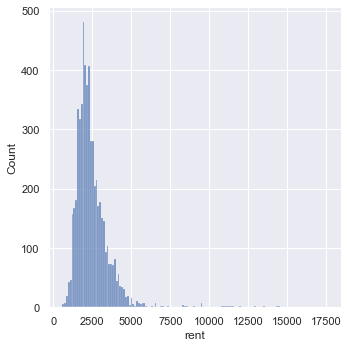

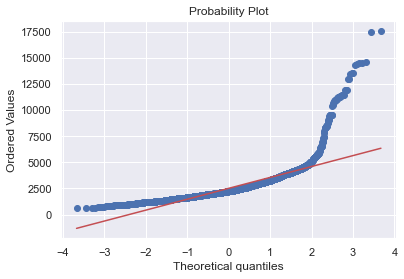

In [18]:
#Distribution of the rent column
sns.displot(units.rent)
fig = plt.figure()
res = stats.probplot(units.rent, plot=plt)

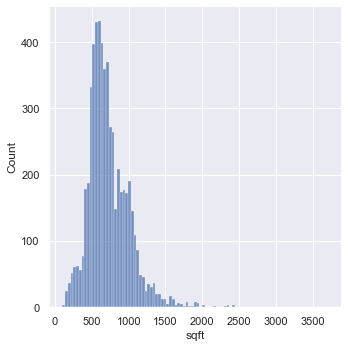

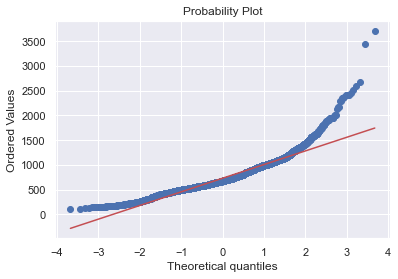

In [19]:
#Distribution of the sqft column
sns.displot(units.sqft)
fig = plt.figure()
res = stats.probplot(units.sqft, plot=plt)

In [20]:
# Detecting possible outliers with standard deviation and IQR 
def outlier_detection(target,df_input):
    
    # Adjust the distributions since they are not normal
    if target == 'rent':
        df_input.loc[:, 'rent'] = np.log(df_input.rent)
    elif target == 'sqft':
        df_input.loc[:, 'sqft'] = np.log(df_input.sqft)
    
    # Boundary zones
    average = df_input.groupby('beds', as_index=True)[target].mean()
    std = df_input.groupby('beds', as_index=True)[target].std()
    upper_limit = average + 3*std
    lower_limit = average - 3*std
    
    # Quartile Range
    iqr_25 = df_input.groupby('beds', as_index=True)[target].quantile(0.25)    
    iqr_75 = df_input.groupby('beds', as_index=True)[target].quantile(0.75)   
    iqr = iqr_75 - iqr_25
    iqr_upper = iqr_75 + iqr
    iqr_lower = iqr_25 - iqr
    
    # Set the conditions for upper limit
    cond1 = df_input[target] > df_input.beds.map(upper_limit)
    cond2 = df_input[target] > df_input.beds.map(iqr_upper)
    
    # Set the conditions for lower limit
    cond3 = df_input[target] < df_input.beds.map(lower_limit)
    cond4 = df_input[target] < df_input.beds.map(iqr_lower)

    outlier_df = df_input[(cond1 & cond2)]
    
    # Take the exponential to revert back to the original data condition
    if target == 'rent':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
    elif target == 'sqft':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
        
    # Filter out any income restriction units
    outlier_df = outlier_df[outlier_df.income_restrictions != 1]
    
    #stats_df.reset_index(inplace=True)
    return outlier_df

In [21]:
# Check for additional outliers in the rent column
outliers = pd.concat([outlier_detection('rent', units.copy()),outlier_detection('rent', units.copy())]).drop_duplicates()
outliers.head()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft
1085,Vitality on 17th,98107,COMMERCIAL,4400.0,0,0.5,1745.0,2022-04-10,2022-04-10,1,...,-122.37852,Ballard,98107,A new building of luxury micro-studios situate...,"additional storage, free bike storage, in unit...",King County,2020,1,https://www.apartments.com/vitality-on-17th-se...,2.521490
5258,Solara,98125,BocaRaton,4779.0,1,1.0,674.0,2022-04-12,2022-04-10,1,...,-122.29302,Lake City,98125,Discover your new home at Solara Luxury Apartm...,"A Multitude of Windows for Natural Light, Barb...",King County,2002,1,https://www.apartments.com/solara-seattle-wa/0...,7.090504
5260,Solara,98125,Captiva,4844.5,1,1.0,677.0,2022-04-19,2022-04-10,1,...,-122.29302,Lake City,98125,Discover your new home at Solara Luxury Apartm...,"A Multitude of Windows for Natural Light, Barb...",King County,2002,1,https://www.apartments.com/solara-seattle-wa/0...,7.155835
5265,Solara,98125,Sanibel,4223.0,0,1.0,612.0,2022-04-13,2022-04-01,1,...,-122.29302,Lake City,98125,Discover your new home at Solara Luxury Apartm...,"A Multitude of Windows for Natural Light, Barb...",King County,2002,1,https://www.apartments.com/solara-seattle-wa/0...,6.900327
5268,Solara,98125,Tahoe,4228.5,0,1.0,499.0,2022-05-18,2022-04-01,1,...,-122.29302,Lake City,98125,Discover your new home at Solara Luxury Apartm...,"A Multitude of Windows for Natural Light, Barb...",King County,2002,1,https://www.apartments.com/solara-seattle-wa/0...,8.473948


In [22]:
# Drop all the extreme outliers as they represent less than 1% of the data (3+ standard deviations away)
units = units[~units.index.isin(outliers.index)]

In [23]:
# Check for additional outliers in the sqft column
outliers = pd.concat([outlier_detection('sqft', units.copy()),outlier_detection('sqft', units.copy())]).drop_duplicates()
outliers.head(10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft
4536,Olympus,98121,001-103,2719.0,1,1.0,1413.0,2022-04-01,2022-04-01,1,...,-122.35344,Belltown,98121,"At Olympus Apartments, located in the exciting...","Controlled Access, Courtesy Patrol, Courtyard,...",King County,2002,1,https://www.apartments.com/olympus-seattle-wa/...,1.924275
8015,Harbor Steps,98101,NE-2407,4190.0,1,1.0,1354.0,2022-04-01,2022-04-01,1,...,-122.33872,Downtown Seattle,98101,"Located on the corner of First and everything,...","Controlled Access, Courtesy Patrol, Granite Co...",King County,1998,1,https://www.apartments.com/harbor-steps-seattl...,3.094535
8017,Harbor Steps,98101,NE-2507,4118.0,1,1.0,1354.0,2022-04-09,2022-04-01,1,...,-122.33872,Downtown Seattle,98101,"Located on the corner of First and everything,...","Controlled Access, Courtesy Patrol, Granite Co...",King County,1998,1,https://www.apartments.com/harbor-steps-seattl...,3.041359
8051,Harbor Steps,98101,SE-24B,5489.0,2,2.0,1836.0,2022-04-12,2022-04-01,1,...,-122.33872,Downtown Seattle,98101,"Located on the corner of First and everything,...","Controlled Access, Courtesy Patrol, Granite Co...",King County,1998,1,https://www.apartments.com/harbor-steps-seattl...,2.989651
8053,Harbor Steps,98101,SE-24F,3911.0,1,1.0,1378.0,2022-04-01,2022-04-01,1,...,-122.33872,Downtown Seattle,98101,"Located on the corner of First and everything,...","Controlled Access, Courtesy Patrol, Granite Co...",King County,1998,1,https://www.apartments.com/harbor-steps-seattl...,2.838171
9231,Epicenter,98103,101,2755.0,1,1.0,1440.0,2022-04-05,2022-04-01,0,...,-122.35075,Fremont,98103,Seattles Fremont District is known as The Cent...,"Ceiling fan master bedroom, Courtyard, Dishwas...",King County,2004,1,https://www.apartments.com/epicenter-seattle-w...,1.913194
9443,Aspira Apartments,98101,3604,5158.0,2,2.0,1797.0,2022-05-02,2022-04-10,1,...,-122.33344,Denny Triangle,98101,"Welcome to Aspira Seattle Apartment Homes, Sea...","10 Foot Ceilings, 4 Star Built-Green Building,...",King County,2010,1,https://www.apartments.com/aspira-apartments-s...,2.870339
9458,4730 California,98116,0210,3200.0,1,1.0,1287.0,2022-04-27,2022-04-01,1,...,-122.38640,Junction,98116,4730 California is more than a place to live; ...,"Additional Storage Available, Balconies*, Coff...",King County,2015,1,https://www.apartments.com/4730-california-sea...,2.486402
9605,The Martin,98121,2009,6320.0,2,2.0,1902.0,2022-04-10,2022-04-10,1,...,-122.34098,Belltown,98121,Introducing The Martin in downtown Seattle – y...,"Air-Conditioning, Balconies*, Bike Storage, Bi...",King County,2013,1,https://www.apartments.com/the-martin-seattle-...,3.322818
9607,The Martin,98121,2109,6260.0,2,2.0,1902.0,2022-04-10,2022-04-10,1,...,-122.34098,Belltown,98121,Introducing The Martin in downtown Seattle – y...,"Air-Conditioning, Balconies*, Bike Storage, Bi...",King County,2013,1,https://www.apartments.com/the-martin-seattle-...,3.291272


In [24]:
# Check for additional outliers in the price/sqft column
outliers = pd.concat([outlier_detection('price/sqft', units.copy()),outlier_detection('price/sqft', units.copy())]).drop_duplicates()
outliers.head(10)

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft
0,418 NE 44th St,98105,12,590.0,1,0.5,100.0,2022-07-02,2022-04-10,0,...,-122.32315,Wallingford,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...,5.900000
359,Vistana,98109,A1,1100.0,0,0.0,157.0,2022-04-10,2022-04-10,1,...,-122.35123,Lower Queen Anne,98109,Units at the Vistana have spacious private bat...,Two Shared Kitchen/Laundry Rooms,King County,2015,1,https://www.apartments.com/vistana-seattle-wa/...,7.006369
367,5902 Ballard,98107,1E,995.0,1,1.0,150.0,2022-04-10,2022-04-10,1,...,-122.38452,Ballard,98107,"Our spacious, modern apartments make residents...",,King County,2015,1,https://www.apartments.com/5902-ballard-seattl...,6.633333
371,5902 Ballard,98107,3A,999.0,1,1.0,173.0,2022-04-10,2022-04-10,1,...,-122.38452,Ballard,98107,"Our spacious, modern apartments make residents...",,King County,2015,1,https://www.apartments.com/5902-ballard-seattl...,5.774566
373,5902 Ballard,98107,3B,925.0,1,1.0,142.0,2022-04-10,2022-04-10,1,...,-122.38452,Ballard,98107,"Our spacious, modern apartments make residents...",,King County,2015,1,https://www.apartments.com/5902-ballard-seattl...,6.514085
375,5902 Ballard,98107,3C,950.0,1,1.0,141.0,2022-04-10,2022-04-10,1,...,-122.38452,Ballard,98107,"Our spacious, modern apartments make residents...",,King County,2015,1,https://www.apartments.com/5902-ballard-seattl...,6.737589
407,Montclair Apartments,98105,501,1900.0,0,0.0,285.0,2022-08-04,2022-04-10,0,...,-122.31563,University District,98105,"Looking for something chic, clear-cut, and com...",,King County,2021,1,https://www.apartments.com/montclair-apartment...,6.666667
411,Montclair Apartments,98105,606,1725.0,0,0.0,244.0,2022-07-06,2022-04-10,0,...,-122.31563,University District,98105,"Looking for something chic, clear-cut, and com...",,King County,2021,1,https://www.apartments.com/montclair-apartment...,7.069672
1031,510 Broadway,98122,310,1199.0,0,0.0,165.0,2022-04-10,2022-04-10,0,...,-122.32037,Minor,98122,Welcome to 510 Broadway! We create communitie...,"Bike Racks, Community Events, Efficient Applia...",King County,2020,1,https://www.apartments.com/510-broadway-seattl...,7.266667
1033,510 Broadway,98122,314,1199.0,0,0.0,173.0,2022-04-10,2022-04-10,0,...,-122.32037,Minor,98122,Welcome to 510 Broadway! We create communitie...,"Bike Racks, Community Events, Efficient Applia...",King County,2020,1,https://www.apartments.com/510-broadway-seattl...,6.930636


In [25]:
# Drop all the extreme outliers as they represent less than 1% of the data (3+ standard deviations away)
units = units[~units.index.isin(outliers.index)]

### Add in additional location featurs
* Distance to seattle and bellevue
* Distance to nearest transit stop

In [26]:
# Calculate the distance to downtown seattle

downtown_seattle = {"lat": 47.604013, "lon": -122.335167}

units['dist_seattle']=units.apply(lambda row: calculate_distance(float(row.latitude), float(row.longitude), downtown_seattle['lat'], downtown_seattle['lon']), axis=1)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft,dist_seattle
1,418 NE 44th St,98105,23,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,...,Wallingford,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...,4.197531,3.932519
3,621 S King St,98104,203,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,...,Chinatown,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.358108,0.605872
4,621 S King St,98104,212,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,...,Chinatown,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.417808,0.605872
5,621 S King St,98104,403,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,...,Chinatown,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,5.608696,0.605872
6,Off Campus Residences,98105,Alta202,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,...,University District,98105,The Off Campus Residences are composed of five...,"Microwave + Refrigerator, Online Resident Port...",King County,2014,0,https://www.apartments.com/off-campus-residenc...,5.172414,4.353582


In [27]:
# Open the train stop location data
train_stops = pd.read_csv("./data/external/seattle_train_stops.txt")[
    ["stop_id", "stop_lat", "stop_lon"]
]

# Open the bus stop location data
bus_stops = pd.read_csv("./data/external/seattle_bus_stops.txt")[
    ["stop_id", "stop_lat", "stop_lon"]
]

In [28]:
# Calculate the distances to the bus and train stops for each apartment complex
units['distBus']=units.apply(lambda row: calculate_distance(float(row.latitude), float(row.longitude), bus_stops['stop_lat'], bus_stops['stop_lon']).min(), axis=1)
units['distTrain']=units.apply(lambda row: calculate_distance(float(row.latitude), float(row.longitude), train_stops['stop_lat'], train_stops['stop_lon']).min(), axis=1)

In [29]:
units['dist_transit'] = np.where(units.distBus < units.distTrain,
                              units.distBus,
                              units.distTrain)

units.drop(columns={'distBus', 'distTrain'}, inplace=True)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft,dist_seattle,dist_transit
1,418 NE 44th St,98105,23,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,...,98105,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...,4.197531,3.932519,0.122959
3,621 S King St,98104,203,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,...,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.358108,0.605872,0.075464
4,621 S King St,98104,212,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,...,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.417808,0.605872,0.075464
5,621 S King St,98104,403,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,...,98104,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,5.608696,0.605872,0.075464
6,Off Campus Residences,98105,Alta202,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,...,98105,The Off Campus Residences are composed of five...,"Microwave + Refrigerator, Online Resident Port...",King County,2014,0,https://www.apartments.com/off-campus-residenc...,5.172414,4.353582,0.076268


In [30]:
# Load the zipcode clusters and map to the data set
with open('./data/seattle_zipcode_clusters.pickle', 'rb') as handle:
    zipcode_cluster_ids = pkl.load(handle)
    
units['zipcode_cluster_id'] = units.zipcode.map(zipcode_cluster_ids)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft,dist_seattle,dist_transit,zipcode_cluster_id
1,418 NE 44th St,98105,23,680.0,1,0.5,162.0,2022-07-02,2022-04-10,0,...,Sq Footage: 2400 sqft.Bedrooms: 7 BedsBathroom...,,King County,NULL,1,https://www.apartments.com/418-ne-44th-st-seat...,4.197531,3.932519,0.122959,3.0
3,621 S King St,98104,203,645.0,0,1.0,148.0,2022-04-10,2022-04-10,0,...,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.358108,0.605872,0.075464,5.0
4,621 S King St,98104,212,645.0,0,1.0,146.0,2022-04-10,2022-04-10,0,...,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,4.417808,0.605872,0.075464,5.0
5,621 S King St,98104,403,645.0,0,1.0,115.0,2022-04-10,2022-04-10,0,...,Our location two minutes south of downtown is ...,,King County,NULL,0,https://www.apartments.com/621-s-king-st-seatt...,5.608696,0.605872,0.075464,5.0
6,Off Campus Residences,98105,Alta202,900.0,0,0.0,174.0,2022-05-19,2022-04-10,0,...,The Off Campus Residences are composed of five...,"Microwave + Refrigerator, Online Resident Port...",King County,2014,0,https://www.apartments.com/off-campus-residenc...,5.172414,4.353582,0.076268,3.0


### Cluster the units based on the lat/long
* Use the mean price/sqft for each location lat/long as a sample weight
* The goal of the clusters is to compute the average price/sqft for the entire cluster to use as a feature

In [31]:
cluster_df = units.groupby(['latitude', 'longitude'], as_index=False)['price/sqft'].mean()
cluster_df.head()

,latitude,longitude,price/sqft
0,47.42516,-122.29549,2.314020
1,47.42541,-122.29679,2.511210
2,47.43398,-122.28464,1.204215
3,47.43928,-122.33700,3.176471
4,47.43988,-122.33566,1.899774


In [32]:
# Import K-means
from sklearn.cluster import KMeans

In [33]:
# Compute the elbow curve to determine the optimal number of clusters

def optimal_cluster():
    # Find the optimal number of clusters to use
    K_clusters = range(5,50)
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    sse =[]

    for k in K_clusters:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(lat_long, sample_weight=weights)
        sse.append(kmeans.inertia_)


    plt.plot(K_clusters, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Curve')
    plt.show()

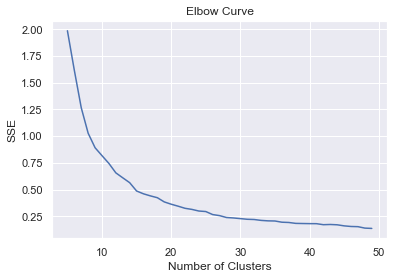

In [34]:
optimal_cluster()

It appears that there's a noticeable elbow point at 9, 12 and 25. For now we'll visualize the cluster of 25 to decide whether or not to use that value.

In [35]:
def clusters(clusters:int):
    # Find the optimal number of clusters to use
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    
    kmeans = KMeans(n_clusters=clusters, **kmeans_kwargs)
    kmeans.fit(lat_long, sample_weight=weights)
    return kmeans

In [36]:
# Assign clusters to units
kmeans = clusters(25)
units['cluster_id'] = kmeans.predict(units[['latitude','longitude']])

In [37]:
fig = px.scatter_mapbox(units, lat="latitude", lon="longitude", color="cluster_id", hover_name="property_zipcode", mapbox_style="carto-positron", zoom=11)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Remove extra columns that aren't useful for visualizing or the model

In [38]:
drop_columns = ['unique_features', 'year_built', 'property_url', 'property_zipcode', 'unit_id', 'description', 'neighborhood', 'property_name', 'city_name', 'latitude', 'longitude', 'zipcode_cluster_id', 'date_scraped', 'date_available', 'zipcode']
units.drop(columns=drop_columns, inplace = True)
units.head()

,rent,beds,baths,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,car_charging,roof,...,elevator,garage,dogs_allowed,cats_allowed,income_restrictions,dishwasher,price/sqft,dist_seattle,dist_transit,cluster_id
1,680.0,1,0.5,162.0,0,0,1,0,0,0,...,0,0,0,1,0,1,4.197531,3.932519,0.122959,2
3,645.0,0,1.0,148.0,0,0,0,1,0,0,...,1,0,0,0,0,0,4.358108,0.605872,0.075464,22
4,645.0,0,1.0,146.0,0,0,0,1,0,0,...,1,0,0,0,0,0,4.417808,0.605872,0.075464,22
5,645.0,0,1.0,115.0,0,0,0,1,0,0,...,1,0,0,0,0,0,5.608696,0.605872,0.075464,22
6,900.0,0,0.0,174.0,0,0,0,1,0,0,...,0,0,0,0,0,0,5.172414,4.353582,0.076268,4


In [39]:
# Save the cleaned dataframe
units.to_csv('./data/sea_cleaned.csv', index=False)

In [40]:
# Export the kmeans model for future use

with open('./data/seattle_clusters.pickle', 'wb') as handle:
    pkl.dump(kmeans, handle)